In [10]:
# ignore if the module is installed in path
import sys
sys.path.append("../")

# import main module
from rppca import Design, randomized_svd, Design1d

# numerical ingredients
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import scipy.io as io
from scipy.sparse.linalg import LinearOperator

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# for single-threading
from threadpoolctl import threadpool_limits

In [2]:
AInv = io.mmread('../datasets/pedAInv.mtx')
LInv = io.mmread('../datasets/pedLInv.mtx')
pop_label = pd.read_csv('../datasets/popLabel.csv').x

In [3]:
type(AInv)

scipy.sparse._coo.coo_matrix

In [4]:
type(AInv.toarray())

numpy.ndarray

In [5]:
AInv.toarray()

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.5       , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5       , 5.5       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 5.45607468, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.53645119,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        4.9972559 ]], shape=(2650, 2650))

In [6]:
# naive SVD
%time A = np.linalg.inv(AInv.toarray())
%time u, s, v = np.linalg.svd(A, full_matrices=False)

CPU times: user 1.83 s, sys: 80.3 ms, total: 1.91 s
Wall time: 613 ms
CPU times: user 24.6 s, sys: 162 ms, total: 24.8 s
Wall time: 6.54 s


In [17]:
# new implementation
with threadpool_limits(limits=1, user_api='blas'):
    %time design = Design(LInv.tocsc())
    %time U, S, V = randomized_svd(design, n_components=10, n_iter=1, seed=0)

CPU times: user 177 μs, sys: 0 ns, total: 177 μs
Wall time: 181 μs
CPU times: user 5.26 ms, sys: 940 μs, total: 6.2 ms
Wall time: 5.92 ms


In [18]:
# eigsh implementation
with threadpool_limits(limits=1, user_api='blas'):

    # use a lambda function define the mv function
    design = Design1d(LInv.tocsc())
    f_mv = lambda x: design.dot_left(design.dot_right(x))
    # the matvec implemented by numba is type-sensitive
    # hence, dtype should be specified in the LinOp definition
    lop = LinearOperator(LInv.shape, matvec=f_mv, dtype=np.float64)
    # 
    %time es, eu = sparse.linalg.eigsh(lop, k=10)

CPU times: user 8.07 ms, sys: 996 μs, total: 9.07 ms
Wall time: 8.85 ms


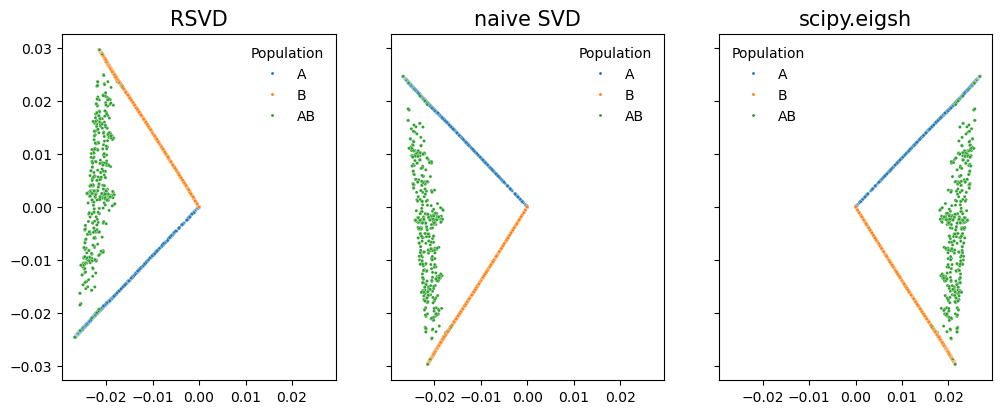

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12,4.5), sharex=True, sharey=True)

# RSVD 
ax[0].set_title('RSVD', fontsize=15)
sns.scatterplot(x=-U[:,0], y=U[:,1], s=5, hue=pop_label, ax=ax[0])

# naive SVD
ax[1].set_title('naive SVD', fontsize=15)
sns.scatterplot(x=u[:,0], y=u[:,1], s=5, hue=pop_label, ax=ax[1])

# scipy-eigsh
# the return value is in an ascending order w.r.t. eigenvalue
ax[2].set_title('scipy.eigsh', fontsize=15)
sns.scatterplot(x=eu[:,9], y=eu[:,8], s=5, hue=pop_label, ax=ax[2])

ax[0].legend(title='Population', frameon=False)
ax[1].legend(title='Population', frameon=False)
ax[2].legend(title='Population', frameon=False)

plt.show()

In [10]:
Lc=LInv.tocsc()

In [11]:
La = LInv.toarray()

In [12]:
vect = np.random.normal(size=2650)

In [13]:
np.array([vect])

array([[-1.38440102,  0.1336049 ,  1.49339855, ...,  1.59676149,
        -0.2897184 , -0.9443406 ]])

In [14]:
%time vect * Lc

CPU times: user 0 ns, sys: 300 μs, total: 300 μs
Wall time: 576 μs


array([-1.38440102,  5.09801389, -0.67570069, ...,  3.72975412,
       -0.68169768, -2.11103025])

In [15]:
%time vect @ La

CPU times: user 13.5 ms, sys: 10.9 ms, total: 24.4 ms
Wall time: 8.26 ms


array([-1.38440102,  5.09801389, -0.67570069, ...,  3.72975412,
       -0.68169768, -2.11103025])

In [16]:
%time np.transpose(np.array([vect])) * La

CPU times: user 90.2 ms, sys: 22.9 ms, total: 113 ms
Wall time: 38.4 ms


array([[-1.38440102, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.1336049 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.49339855, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.72975412,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.68169768, -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -2.11103025]])

In [17]:
%time np.transpose(vect) * La

CPU times: user 108 ms, sys: 24.9 ms, total: 133 ms
Wall time: 37.2 ms


array([[-1.38440102,  0.        ,  0.        , ...,  0.        ,
        -0.        , -0.        ],
       [-0.        ,  0.1336049 ,  0.        , ...,  0.        ,
        -0.        , -0.        ],
       [-0.        ,  0.        ,  1.49339855, ...,  0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        ,  0.        ,  0.        , ...,  3.72975412,
        -0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.68169768, -0.        ],
       [-0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.        , -2.11103025]])

In [18]:
%time np.transpose(np.array([vect])) @ La

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2650 is different from 1)

In [19]:
%time np.transpose(vect) * Lc 

CPU times: user 346 μs, sys: 14 μs, total: 360 μs
Wall time: 309 μs


array([-1.38440102,  5.09801389, -0.67570069, ...,  3.72975412,
       -0.68169768, -2.11103025])

In [20]:
%time np.transpose(vect) @ Lc 

CPU times: user 192 μs, sys: 8 μs, total: 200 μs
Wall time: 170 μs


array([-1.38440102,  5.09801389, -0.67570069, ...,  3.72975412,
       -0.68169768, -2.11103025])

In [21]:
%time Lc @ vect 

CPU times: user 170 μs, sys: 7 μs, total: 177 μs
Wall time: 469 μs


array([-1.38440102,  0.1336049 ,  1.49339855, ...,  5.27915291,
        2.75139662, -0.40595772])

In [22]:
%time Lc * Lc

CPU times: user 0 ns, sys: 447 μs, total: 447 μs
Wall time: 394 μs


<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 16707 stored elements and shape (2650, 2650)>